In [32]:
import tkinter as tk
from tkinter import ttk
import os
from tkinter import filedialog
from typing import List
import xlstools
from xlstools import open_workbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from itertools import product

def lista_contenida(lista_pequena, lista_grande):
    # Convertimos las listas en conjuntos para aprovechar la eficiencia de las operaciones de conjuntos
    conjunto_pequeno = set(lista_pequena)
    conjunto_grande = set(lista_grande)
    
    # Verificamos si conjunto_pequeno es un subconjunto de conjunto_grande
    return conjunto_pequeno.issubset(conjunto_grande)

SPATIAL_RESOLUTION = 0.1 #cm
BIN_WIDTH = 1 #cGy
DOSE_UNIT = 'cGy'
VOLUME_UNIT = '%'
MAX_DOSE_ABS_VOLUME = 0.03 #cm3
corrected_dict = {}

In [33]:
class Structure:
    def __init__(self, label, dose_axis, cumulated_percent_volume_axis):
        self.label = 'Paciente' if label == 'Paciente(Unsp.Tiss.)' else label
        self.volume = None
        self.dose_axis = dose_axis
        self.cumulated_percent_volume_axis = cumulated_percent_volume_axis
        self.differential_percent_volume_axis = -np.diff(self.cumulated_percent_volume_axis, 
                                              axis=0, 
                                              prepend=self.cumulated_percent_volume_axis[0])
        self.mean = self._mean_calculation()
        self.constraints = []

    def _mean_calculation(self):
        sum_dummy = (self.differential_percent_volume_axis*self.dose_axis).sum()
        sum_dummy /= self.differential_percent_volume_axis.sum()
        sum_dummy -= 1
        return sum_dummy

    def volume_update(self, volume: float) -> None:
        self.volume = volume

    def volume_function(self, dose):   # Entrada de dosis en cGy, devuelve en porcentaje de volumen
        dvh = interp1d(self.dose_axis, self.cumulated_percent_volume_axis, kind='quadratic')
        return round(dvh(dose), 1)
    
    def dose_function(self, volume):   # Entrada de volumen en porcentaje, devuelve dosis en cGy
        vdh = interp1d(self.cumulated_percent_volume_axis, self.dose_axis, kind='quadratic')
        return round(vdh(volume), 1)

class DVH:
    def __init__(self, file_path):
        # self.file_path = self._file_finder('Seleccione el archivo DVH.')
        self.file_path = file_path
        self.patient_id, self.plan_name, self.date_and_time, self.structures = self._DVH_data_parser()

    def _file_finder(self, window_title: str) -> str:
        tk.Tk().withdraw() # prevents an empty tkinter window from appearing
        my_directory = filedialog.askopenfilename(initialdir=os.getcwd(), 
                                           title=window_title, 
                                           filetypes=[("TXT Files", "*.txt")])
        return(my_directory)

    def _DVH_data_parser(self) -> List:
            try:
                with open(self.file_path, 'r') as file:
                    data = file.readlines()
                    header = data[0]

                    patient_id = header.split(' ')[2]
                    plan_name = header.split(' ')[6]
                    date_and_time = data[-1]

                    data_dict = {}
                    for row in data[3:-3]:
                        row = row.replace('\n','').split('                    ')
                        key = row[0]
                        values = [float(row[1]), float(row[2])]
                        
                        # Verificar si la key ya existe en el diccionario
                        if key in data_dict.keys():
                            data_dict[key].append(values)
                        else:
                            data_dict[key] = [values]

                    structures_dict = {}
                    for key in data_dict:
                        # convierto a numpy.array para poder transponer
                        dummy = np.array(data_dict[key]).T
                        if key in ['Camilla', 'Espuma', 'isoctsim']:     # Estructuras que no nos interesa evaluar
                            continue
                        structures_dict[key.upper()]= Structure(key.upper(),dummy[0],dummy[1])
                           
                    return patient_id, plan_name, date_and_time, structures_dict
                
            except FileNotFoundError:
                print(f"El archivo '{self.archivo}' no fue encontrado.")
            except Exception as e:
                print(f"Error al leer el archivo: {e}")

    def plot(self, DIFFERENTIAL_DVH: bool=False) -> None:
        print('Resumen de datos del DVH ingresado:')
        print(self.patient_id)
        print(self.plan_name)
        print(self.date_and_time)
        print('\n')

        plt.figure()
        for structure in list(self.structures.values()):
            print(f'{structure.label}:\t{structure.mean:.1f} cGy')
            if DIFFERENTIAL_DVH:
                plt.plot(structure.dose_axis, 
                         structure.differential_percent_volume_axis, 
                         label=structure.label)
                plt.title('Differential dose-volume histogram')
                plt.ylim([0,1.5])
            else:
                plt.plot(structure.dose_axis, 
                         structure.cumulated_percent_volume_axis, 
                         label=structure.label)
                plt.title('Cumulated dose-volume histogram')
     
        plt.xlabel('Dosis[cGy]')
        plt.ylabel('Volume[%]')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.show()


In [24]:
class Constraint:
    def __init__(self, constraints_chart_line):
        self.structure_name, self.type, self.ideal_dose, self.ideal_volume, self.acceptable_dose, self.acceptable_volume = constraints_chart_line
        self.structure_name = self.structure_name.upper()
        self.VERIFIED_IDEAL = (False, 0.0)
        self.VERIFIED_ACCEPTABLE = (False, 0.0)
        self.ACCEPTABLE_LV_AVAILABLE = self.acceptable_dose != 'None'

    def _evaluate(self, structure, ref1, ref2):   #ref1 y ref2 despues podran ser contraint ideal o aceptable
        constraint_types = ['V(D)>V_%', 'V(D)>V_cc', 'V(D)<V_%', 'V(D)<V_cc', 'D(V_%)<D', 'D(V_cc)<D', 'Dmax', 'Dmedia']

        if self.type in constraint_types[:4]:
            is_superior = self.type in (constraint_types[2], constraint_types[3])
            abs_volume = self.type in (constraint_types[1], constraint_types[3])

            ref_dose = float(ref1)
            ref_vol  = float(ref2)
            result = structure.volume_function(ref_dose)
            result = result * structure.volume/100.0 if abs_volume else result
            # print(f'dvh percent: {result}')
            if (is_superior and result <= ref_vol) or (not is_superior and result >= ref_vol):
                PASS = True
            else:
                PASS = False
            return (PASS, round(result, 1))
            
            
        elif self.type in constraint_types[4:6]:
            abs_volume = self.type == constraint_types[5]

            ref_vol   = float(ref1)  #cc
            ref_vol   = float( ref_vol*100.0/structure.volume if abs_volume else ref_vol ) #%
            ref_dose = float(ref2)
            result = structure.dose_function(ref_vol)
            # print(f'vdh percent: {result}')
            if result <= ref_dose:
                PASS = True
            else:
                PASS = False
            return (PASS, round(result, 1))
            
        elif self.type in constraint_types[6:]:
            dmax       = self.type == constraint_types[6]
            dmed       = self.type == constraint_types[7]

            if dmax:
                ref_vol   = float( MAX_DOSE_ABS_VOLUME * 100.0/structure.volume)  #%
            ref_dose  = float(ref1)
            result = structure.mean if dmed else structure.dose_function(ref_vol)
            # print(f'med o max: {result}')
            if result <= ref_dose:
                PASS = True
            else:
                PASS = False
            return (PASS, round(result, 1))
            
        else:
            PASS = False
            print('No existe el tipo de constraint en las lista de tipos de constraints.')
            return (PASS, 'None')


    def verify(self, structure: Structure):   
        self.VERIFIED_IDEAL = self._evaluate(structure, self.ideal_dose, self.ideal_volume)

        if not self.VERIFIED_IDEAL[0] and self.ACCEPTABLE_LV_AVAILABLE:
            self.VERIFIED_ACCEPTABLE = self._evaluate(structure, self.acceptable_dose, self.acceptable_volume) 
            


class Prescription:
    def __init__(self, constraint_excel_filepath, presc_template_name):
        self.constraint_excel_filepath = constraint_excel_filepath
        self.presc_template_name = presc_template_name.upper()
        self.structures = {}

        constraints_chart = self._prescription_importer()

        target_chart = constraints_chart.pop(0)
        constraints_chart = [sublist[1:] for sublist in constraints_chart[0]]


        self.target_structures = {}
        for target_structure in target_chart:
            self.target_structures[target_structure[0]] = [int(x) for x in target_structure[1:3]]

        for constraint_chart_line in constraints_chart:
            new_structure_name = constraint_chart_line[0]
            if new_structure_name != 'None':
                structure_name = new_structure_name.upper()
                self.structures[structure_name] = []
                self.structures[structure_name].append(Constraint(constraint_chart_line))
            else:
                self.structures[structure_name].append(Constraint(constraint_chart_line))   

            
    def _prescription_importer(self):
        # workbook = openpyxl.load_workbook(self.constraint_excel_filepath)
        # for name in workbook.sheetnames:
        #     print(name)
        excel_data = xlstools.cell_data_importer(open_workbook(self.constraint_excel_filepath, self.presc_template_name),
                                                (4,'A'), 
                                                (45,'G'))

        chunks_charts = xlstools.none_based_data_parser(excel_data)

        assert len(chunks_charts)==2, "Error de importacion de chunks. Numero de chunks: "+f'{len(chunks_charts)}'
        if len(chunks_charts)==2:
            constraints_chart = [chunks_charts[0][1:], chunks_charts[1][2:]]

        return constraints_chart

    def print(self):
        print(f'Resumen de datos ingresados de la prescripcion: {self.presc_template_name}')
        print(f'PATH: {self.constraint_excel_filepath}')
        for structure_name, content in self.target_structures.items():
            print(f'{structure_name}:\t',content)
        
        dummy = []
        for structure_name, constraints in self.structures.items():
            for constraint in constraints:
                if constraint.VERIFIED_IDEAL[0]:
                    check = f'    PASS IDEAL: {constraint.VERIFIED_IDEAL[1]}'  
                elif constraint.VERIFIED_ACCEPTABLE[0]:
                    check = f'    PASS ACEPTABLE: {constraint.VERIFIED_ACCEPTABLE[1]}'
                else:
                    check = f'    FAIL: {constraint.VERIFIED_ACCEPTABLE[1]}'
                dummy.append([structure_name, constraint.type, constraint.ideal_dose, constraint.ideal_volume, constraint.acceptable_dose, constraint.acceptable_volume, check])
        print(pd.DataFrame(dummy).to_string(header=False, index=False))


In [30]:
def request_needed_volume(dvh: DVH, presc: Prescription):
    '''Chequea si las estructuras en dvh necesitan valor de volumen
    segun la presc elegida. Devuelve una lista con los nombres de las estructuras
    que necesitan volumen.'''
    need_volume = ['V(D)>V_cc', 'V(D)<V_cc', 'D(V_cc)<D', 'Dmax']
    # for dvh_structure in dvh.structures: print(dvh_structure.label)
    structures_needing_volume = []
    for dvh_structure in list(dvh.structures.values()):
        if dvh_structure.label not in presc.structures.keys():
            continue
        for constraint in presc.structures[dvh_structure.label]:
            if constraint.type in need_volume:
                if dvh_structure.volume is not None:
                    continue
                else:
                    structures_needing_volume.append(dvh_structure.label)

    return list(set(structures_needing_volume))

def structures_volume_entry(dvh_list_dummy: List, structures_needing_volume):
    def submit_values():
        for i, entry in enumerate(entry_fields):
            try:
                value = float(entry.get())
                labels[i].config(text=f"{structures_needing_volume[i]}: {value}")

                for name in structures_needing_volume:
                    dvh_list_dummy[0].structures[name].volume = value
                
            except ValueError:
                labels[i].config(text=f"{structures_needing_volume[i]}: Invalid input")
        
        root.destroy()   

    root = tk.Tk()
    root.title("Ingrese el volumen de las estructuras")

    labels = []
    entry_fields = []

    for text in structures_needing_volume:
        label = tk.Label(root, text=text)
        label.pack()
        entry = tk.Entry(root)
        entry.pack()
        labels.append(label)
        entry_fields.append(entry)

    submit_button = tk.Button(root, text="Ok", command=submit_values)
    submit_button.pack()

    root.mainloop()

def match_strings(list1, list2):
    def get_replacement_dict():
        corrected_dict = {}
        misspelled_strings = [item2 for item2 in list2 if item2 not in list1]  # Get only misspelled strings

        for i, var in enumerate(selected_vars):    #en selected_vars estan los elementos de list2 elegidos
            value = var.get()
            if value != "":
                index = list2.index(misspelled_strings[i])  # Find the index of the misspelled string in list2
                corrected_dict[list2[index]] = value  # Add the correct value to the dictionary
            # else:
            #     print(f'Estructura con el mismo nombre: {list2[i]}')  # If no correction was made, use the original string

        # Add the strings that were already present in list1
        for item in list2:
            if item not in corrected_dict:
                corrected_dict[item] = item

        list2[:] = list(corrected_dict.values())

        root.destroy()

    root = tk.Tk()
    root.title("Mismatch de estructuras")

    label_title = tk.Label(root, text="Empareje las estructuras del plan con la correspondiente en la prescripción.")
    label_title.grid(row=0, columnspan=2)

    selected_vars = []
    row_count = 1  # Keep track of the current row

    for i, item2 in enumerate(list2):
        if item2 not in list1:  # Show only misspelled strings
            label = tk.Label(root, text=item2)
            label.grid(row=row_count, column=0)

            var = tk.StringVar()
            dropdown = ttk.Combobox(root, textvariable=var, values=list1)
            dropdown.grid(row=row_count, column=1)

            selected_vars.append(var)
            row_count += 1

    # Create a frame to hold the "OK" button at the bottom
    button_frame = tk.Frame(root)
    button_frame.grid(row=row_count, columnspan=2, sticky="ew")

    ok_button = tk.Button(button_frame, text="OK", command=get_replacement_dict)
    ok_button.pack(pady=10)  # Add padding to the button

    root.mainloop()


def dose_police_in_action(dvh_list_dummy: List, presc: Prescription):
    # CHEQUEANDO SI COINCIDEN LOS NOMBRES DE LAS ESTRUCTURAS EN PRESCRIPCION Y DVH
    dvh_structure_names = list(dvh_list_dummy[0].structures.keys())
    presc_structure_names = list(presc.structures.keys())

    match_strings(presc_structure_names, dvh_structure_names)

    if not lista_contenida(presc_structure_names, dvh_structure_names):
        print('Error: Hay estructuras del protocolo de constraints que no estan en el plan.')

    for i, structure_name in enumerate(list(dvh_list_dummy[0].structures.keys())): 
        dvh_list_dummy[0].structures[structure_name].label = dvh_structure_names[i]
        dvh_list_dummy[0].structures = {(dvh_structure_names[i] if clave == structure_name else clave): valor for clave, valor in dvh_list_dummy[0].structures.items()}

    # CHEQUEANDO SI SE NECESITA INGRESAR EL VALOR DE VOLUMEN DE ALGUNA ESTRUCTURA
    structures_needing_volume = request_needed_volume(dvh_list_dummy[0], presc)
    # print(f'Estructuras que necesitan volumen: {structures_needing_volume}')

    if structures_needing_volume:
        structures_volume_entry(dvh_list_dummy, structures_needing_volume)

    

    # for structure in dvh_list_dummy[0].structures:
    #     print(f'{structure.label}: {structure.volume} cc')

    # print('Estructuras presc:')
    # for name in presc_structure_names:
    #     print(name)
    # print('Estructuras dvh:')
    # for structure in dvh_list_dummy[0].structures:
    #     print(structure.label)

    # CHEQUEANDO CONSTRAINTS
    for p_name in list(presc.structures.keys()):
        # print(f'Presc: {p_name} VS DVH: {structure.label}')
            print(f'    Verifying...                                        {p_name}:')
            for constraint in presc.structures[p_name]:
                
                constraint.verify(dvh_list_dummy[0].structures[p_name])

                if not constraint.ACCEPTABLE_LV_AVAILABLE:
                    if constraint.VERIFIED_IDEAL[0]:
                        print(f'PASA IDEAL: {constraint.type}: {constraint.ideal_dose} {constraint.ideal_volume} -> {constraint.ideal_dose} {constraint.VERIFIED_IDEAL[1]}')
                    else:
                        print(f'NO PASA: {constraint.type}: {constraint.ideal_dose} {constraint.ideal_volume} -> {constraint.ideal_dose} {constraint.VERIFIED_IDEAL[1]}')
                else:
                    if constraint.VERIFIED_ACCEPTABLE[0]:
                        print(f'PASA ACEPTABLE: {constraint.type}: {constraint.acceptable_dose} {constraint.acceptable_volume} -> {constraint.acceptable_dose}{constraint.VERIFIED_ACCEPTABLE[1]}')
                    else:
                        print(f'NO PASA: {constraint.type}: {constraint.acceptable_dose} {constraint.acceptable_volume} -> {constraint.acceptable_dose} {constraint.VERIFIED_ACCEPTABLE[1]}')

  

Resumen de datos del DVH ingresado:
1~11345726
PRmVSmLN
2024-06-13-Thu  11:15:09


BULBO_PENEANO:	2141.7 cGy
CAUDA_EQUINA:	1353.7 cGy
FEMUR_D:	1507.3 cGy
FEMUR_I:	1436.1 cGy
INTESTINOS:	1283.7 cGy
ISOAUTOCONTOUR:	7189.0 cGy
LN_PELVICO_NRG:	4964.6 cGy
PACIENTE(UNSP.TISS.):	1037.2 cGy
PENE:	360.7 cGy
PROSTATA:	7108.6 cGy
PRV_CAUDA_EQUINA:	1421.3 cGy
PTV_LN:	4966.2 cGy
PTV_PR:	7103.2 cGy
PTV_VS:	7112.0 cGy
RECTO:	3488.7 cGy
VEJIGA:	4346.8 cGy
VES_SEMIN:	7151.5 cGy


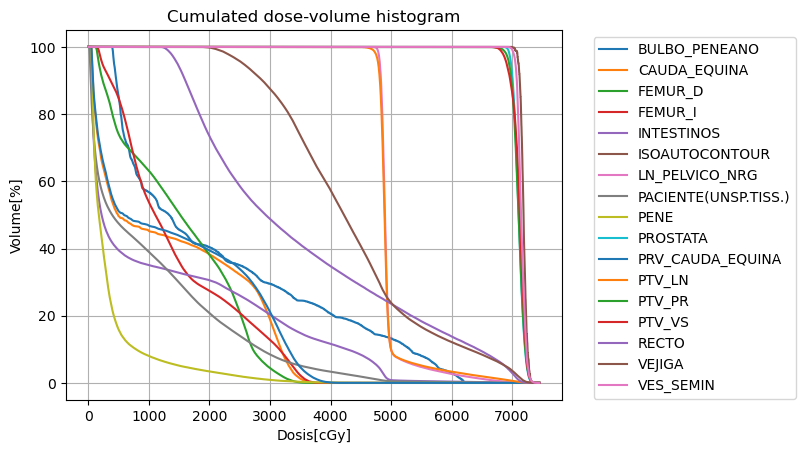

BULBO_PENEANO BULBO_PENEANO None
CAUDA_EQUINA CAUDA_EQUINA 34.955
FEMUR_D FEMUR_D None
FEMUR_I FEMUR_I None
INTESTINOS INTESTINOS 2522.003
ISOAUTOCONTOUR ISOAUTOCONTOUR None
LN_PELVICO_NRG LN_PELVICO_NRG None
PACIENTE(UNSP.TISS.) PACIENTE(UNSP.TISS.) None
PENE PENE 85.642
PROSTATA PROSTATA None
PRV_CAUDA_EQUINA PRV_CAUDA_EQUINA None
PTV_LN PTV_LN None
PTV_PR PTV_PR 133.469
PTV_VS PTV_VS 29.942
RECTO RECTO None
VEJIGA VEJIGA None
VES_SEMIN VES_SEMIN None
    Verifying...                                        PTV_PR:


TypeError: type numpy.ndarray doesn't define __round__ method

In [34]:
file_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/11345726_PRmVSmLN_DVH_1.txt'
dvh = DVH(file_path)
# PLOTEO Y PRINTEO DE DATOS INGRESADOS
dvh.plot()

# SETEO MANUAL DEL VOLUMEN DE LA MEDULAR
OARs_volumes = {'INTESTINOS': 2522.003, 'PENE': 85.642, 'PTV_VS': 29.942, 'CAUDA_EQUINA': 34.955,'PTV_PR': 133.469}
for key,value in OARs_volumes.items():
        dvh.structures[key].volume_update(value)

for name, structure in dvh.structures.items():
    print(name, structure.label, structure.volume)

constraint_excel_file_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-PreScript/protocols/Protocolo de constraints.xlsx'
presc_template_name = 'PR+VS+LN 7020-27FX'

presc = Prescription(constraint_excel_file_path, presc_template_name)

# presc.print()

dose_police_in_action([dvh], presc)   

In [ ]:
dvh.plot()

for structure in dvh.structures:
    if structure.label in ['PTV_T', 'PTV_VS']:
        print(f'{structure.label}: {structure.volume_function(0.98*7020)}')
    if structure.label in ['PTV_LN']:
        print(f'{structure.label}: {structure.volume_function(0.98*4680)}')

In [ ]:
for structure in dvh.structures:
    print(f'Nombre: {structure.label}')
    print(f'        dvh: {structure.volume_function(2000)}')
    print(f'        vdh: {structure.dose_function(80)}')

In [ ]:
print(np.__version__)

1.25.2
